In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [2]:
warnings.filterwarnings("ignore")


In [4]:
#Loading historical data 
# Load datasets
sp500_df = pd.read_csv(r"C:\Users\sushm\OneDrive\Desktop\AAPL SP500.csv")
nasdaq_df = pd.read_csv(r"C:\Users\sushm\OneDrive\Desktop\AAPL NASDQ.csv")
forbes_df = pd.read_csv(r"C:\Users\sushm\OneDrive\Desktop\AAPL Forbes200.csv")


In [5]:
#Formatting the Date Columns
for df in [sp500_df, nasdaq_df, forbes_df]:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.drop_duplicates(inplace=True)


In [6]:
#Merging all 3 datasets
merged_df = pd.merge(sp500_df[['Date', 'Close']], nasdaq_df[['Date', 'Close']], on='Date', suffixes=('_sp500', '_nasdaq'))
merged_df = pd.merge(merged_df, forbes_df[['Date', 'Close']], on='Date')
merged_df.rename(columns={'Close': 'Close_forbes'}, inplace=True)


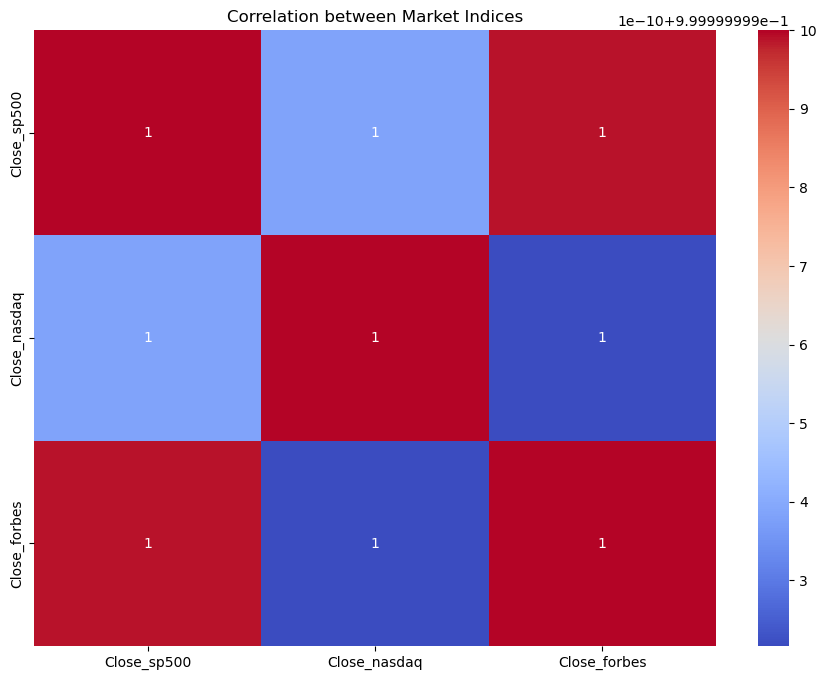

In [8]:
#Finding the correlation
plt.figure(figsize=(11, 8))
sns.heatmap(merged_df[['Close_sp500', 'Close_nasdaq', 'Close_forbes']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Market Indices")
plt.show()


In [10]:
#Creating a prediction label
merged_df['Future_Close'] = merged_df['Close_sp500'].shift(-5)
merged_df['Next_Week'] = np.where(merged_df['Future_Close'] > merged_df['Close_sp500'], 1, 0)
merged_df.dropna(inplace=True)


In [13]:
#Train the Model
X = merged_df[['Close_sp500', 'Close_nasdaq', 'Close_forbes']]
y = merged_df['Next_Week']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [14]:
##EvaluatING the model
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Model Accuracy: 0.5137724550898204
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       406
           1       0.51      1.00      0.68       429

    accuracy                           0.51       835
   macro avg       0.26      0.50      0.34       835
weighted avg       0.26      0.51      0.35       835



In [16]:
#Fetching real-time AAPL + Market Data for April 17–24, 2025
start_date = "2025-04-17"
end_date = "2025-04-24"

sp500_live = yf.download("^GSPC", start=start_date, end=end_date)
nasdaq_live = yf.download("^IXIC", start=start_date, end=end_date)
forbes_live = yf.download("AAPL", start=start_date, end=end_date)  # Using AAPL as Forbes proxy

start_date = "2025-04-17"
end_date = "2025-04-24"

sp500_live = yf.download("^GSPC", start=start_date, end=end_date)
nasdaq_live = yf.download("^IXIC", start=start_date, end=end_date)
forbes_live = yf.download("AAPL", start=start_date, end=end_date)  # Using AAPL as Forbes proxy

live_df = pd.DataFrame({
    "Date": sp500_live.index,
    "Close_sp500": sp500_live["Close"].values.flatten(),  # flatten in case it's 2D
    "Close_nasdaq": nasdaq_live["Close"].values.flatten(),
    "Close_forbes": forbes_live["Close"].values.flatten()
})

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
live_df = pd.DataFrame({
    "Date": sp500_live.index,
    "Close_sp500": sp500_live["Close"].values.flatten(),  # flatten in case it's 2D
    "Close_nasdaq": nasdaq_live["Close"].values.flatten(),
    "Close_forbes": forbes_live["Close"].values.flatten()
})


In [20]:
live_df['Prediction'] = model.predict(
    live_df[['Close_sp500', 'Close_nasdaq', 'Close_forbes']]
)

live_df['Trend'] = live_df['Prediction'].map({1: "Rise 📈", 0: "Fall 📉"})

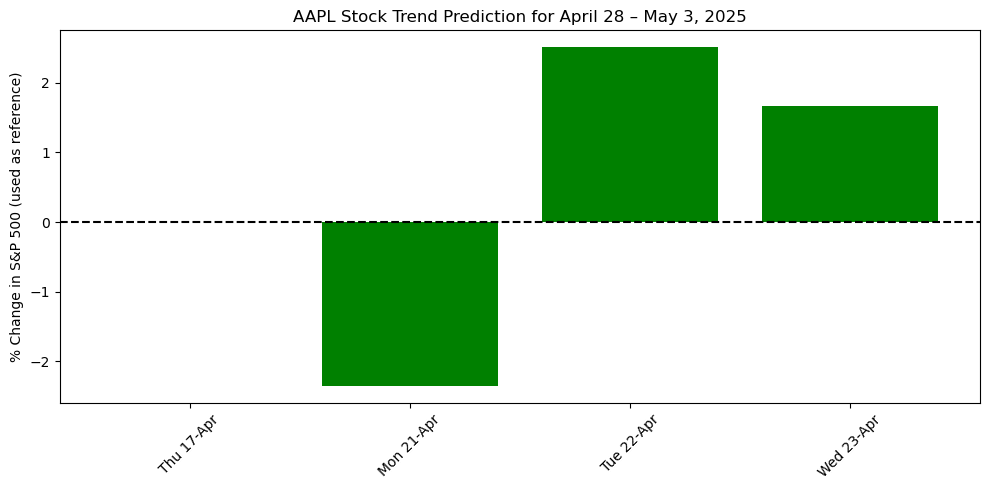

In [21]:
#Visualization
plt.figure(figsize=(10, 5))
# Map 1→green, 0→red
colors = live_df['Prediction'].map({1: "green", 0: "red"})
pct_changes = live_df['Close_sp500'].pct_change().fillna(0) * 100
plt.bar(
    live_df['Date'].dt.strftime("%a %d-%b"),
    pct_changes,
    color=colors
)

plt.axhline(0, color='black', linestyle='--')
plt.title("AAPL Stock Trend Prediction for April 28 – May 3, 2025")
plt.ylabel("% Change in S&P 500 (used as reference)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()